# Script para plotar mapas de calor, a partir de saídas corrigidas do PurpleAir
Desenvolvido por Nicole Laureanti - nlaureanti@gmail.com

Bibliotecas utilizadas: cartopy, scipy

Tarefas: Concatenação de diferentes planilhas corrigidas do PurpleAir (saídas do script_conferedados) + leitura de coordenadas + Cálculo de valores médios, máximos e mínimos horários e diários + Interpolação dos dados utilizados + Plotagem do mapa de calor

NESSA VERSÃO::::
Gráficos individuais para saídas diárias/horárias de mapas de calor

Pré-execução: instalar bibliotecas em um ambiente conda

Ref:<https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html>

conda activate PurpleAir

conda install -c conda-forge cartopy

conda install -c conda-forge scipy

conda install -c conda-forge openpyxl


In [1]:
import pandas as pd    # conjunto de funções que se usa para dados em tabela (csv)
#https://pandas.pydata.org/docs/index.html
import matplotlib.pyplot as plt # conjunto de funções que se usa para plotagem 
#https://matplotlib.org/stable/index.html
import numpy as np #para trabalhar com vetores/arrays


import cartopy.crs as ccrs #para introduzir os eixos cartográficos

from scipy.interpolate import griddata as gd #para interpolar os dados
from mpl_toolkits.axes_grid1.inset_locator import inset_axes #para movimentar o eixo que possui a colorbar
from scipy.ndimage.filters import gaussian_filter  #filtro para suavizar o campo pós-interpolação
import matplotlib.transforms as mtransforms # para transformar eixos

/tmp/ipykernel_154229/2000906256.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter  #filtro para suavizar o campo pós-interpolação


# Fazendo a leitura das coordenadas

In [2]:
fname_locais='Números_ID_PA.xlsx'
df_locais=pd.read_excel(fname_locais,
                      header=2, index_col=0, usecols=["LOCAL","COORD LAT","COORD LONG"])
print(df_locais)

                       COORD LAT  COORD LONG
LOCAL                                       
IFPR                  -25.586150  -48.563952
RF                    -25.504336  -48.517748
ILHA                  -25.572444  -48.313248
RESERVA DAS ÁGUAS     -25.382222  -48.783611
RESERVA DA GUARICICA  -25.314958  -48.696156
RESERVA DOS PAPAGAIOS -25.223289  -48.454511
TCP                   -25.500682  -48.497700
APPA                  -25.503349  -48.519058
PLUGFIELD             -25.503490  -48.519370


# Arquivos de entrada (preparando a execução):

In [3]:
fnames=['Ilha do Mel corrigido.csv',        'Reserva dos Papagaios corrigido.csv',
'Reserva das Águas corrigido.csv',              'RF 20211010-20211016 corrigido.csv',
'Reserva da Guaricica (outside) (-25.314958 -48.696156) Primary Real Time 05_05_2022 05_07_2022-corrigido.csv'
]
pasta_arq='./corrigidos_mapadecalor/'

In [4]:
#Atribuir a coordenada ao nome do arquivo
vetor_lat=[] ;vetor_lon=[]
list_estacao=[]
name_estacao=[]
for loc in range(len(df_locais.index)):
    for f in fnames:
        if df_locais.index[loc] in f.upper(): 
            #condição para verificação do nome do arquivo e atribuição de coordenada
            print(f"loc: {loc} {df_locais.index[loc]} ok {f.upper()}")
            vetor_lat.append(df_locais["COORD LAT"][loc])
            vetor_lon.append(df_locais["COORD LONG"][loc])
            list_estacao.append(f"{pasta_arq}/{f}")
            name_estacao.append(df_locais.index[loc])
print(name_estacao) 
print(vetor_lat)
print(vetor_lon) 


loc: 1 RF ok RF 20211010-20211016 CORRIGIDO.CSV
loc: 2 ILHA  ok ILHA DO MEL CORRIGIDO.CSV
loc: 3 RESERVA DAS ÁGUAS ok RESERVA DAS ÁGUAS CORRIGIDO.CSV
loc: 4 RESERVA DA GUARICICA ok RESERVA DA GUARICICA (OUTSIDE) (-25.314958 -48.696156) PRIMARY REAL TIME 05_05_2022 05_07_2022-CORRIGIDO.CSV
loc: 5 RESERVA DOS PAPAGAIOS ok RESERVA DOS PAPAGAIOS CORRIGIDO.CSV
['RF', 'ILHA ', 'RESERVA DAS ÁGUAS', 'RESERVA DA GUARICICA', 'RESERVA DOS PAPAGAIOS']
[-25.504336, -25.572444, -25.382222, -25.314958, -25.223289]
[-48.517748, -48.313248, -48.783611, -48.696156, -48.454511]


In [5]:
#função para fazer a abertura dos arquivos
def get_data(f):
    try:
        df=pd.read_csv(f,
                      sep=',',header=0, index_col=0,
                       parse_dates=["dates"], na_values='NaN') #arquivo online
    except:
        df=pd.read_csv(f,
                      sep=',',header=0, index_col=0,
                       parse_dates=["UTCDateTime"], na_values='NaN') #arquivo do SD
    return df

In [6]:
#Crio o grid 
dfs=[];xs=[];ys=[]
for i in range(len(name_estacao)):
    print(name_estacao[i])
    xs.append(vetor_lon[i])
    ys.append(vetor_lat[i])
    
    dfs.append(get_data(list_estacao[i]))
    print(xs[i],ys[i])
    #print(loc,xs,ys,name_estacao[i],'\n',dfs[i])
xs, ys = np.array(xs), np.array(ys)  #criar o grid dos dados

RF
-48.517748 -25.504336
ILHA 
-48.313248 -25.572444
RESERVA DAS ÁGUAS
-48.783611 -25.382222
RESERVA DA GUARICICA
-48.696156 -25.314958
RESERVA DOS PAPAGAIOS
-48.454511 -25.223289


In [7]:
#função para interpolar o dado dentro do grid
def interpolar_xy(datax,datay,dataz):
    # Interpolation: Generate grid data of latitude and longitude
    numcols, numrows = 100, 100
    xi = np.linspace(np.min(datax), np.max(datax), numcols)
    yi = np.linspace(np.min(datay), np.max(datay), numrows)
    xi, yi = np.meshgrid(xi, yi)    
     
    zi = gd(
            (datax,datay),
            dataz,
            (xi, yi),
            method='nearest')
    zi = gaussian_filter(zi, 5) 
    return xi, yi, zi    

In [8]:
#Função para plotar o arquivo shapefile
def plot_shape(fname,ax,color='none'):
    from cartopy.io.shapereader import Reader
    """ PLOTS EVERY SHAPE """

    ax.add_geometries(Reader(fname).geometries(),
                  ccrs.PlateCarree(),
                  facecolor=color, hatch=None, edgecolor='black')
  

# 1º Plot: mapa da estações

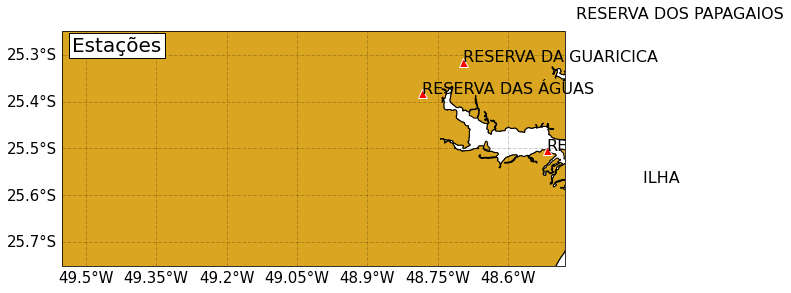

In [10]:
#[ print(f" {name_estacao[i]} {xs[i]} {ys[i]} \n {matrix[i]} ") for i in range(len(name_estacao)) ]

proj = ccrs.PlateCarree() 
#cria a projeção do mapa # https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html
fig, ax = plt.subplots(1,figsize=(9,14),
                   subplot_kw=dict(projection=proj),
                   sharex=True,sharey=True,
                   gridspec_kw={'hspace': 0, 'wspace':0}
                      )
for d in range(1):
    ax.set_extent((-49.55,-48.48,-25.75,-25.25), crs=proj) #define os limites do mapa
    shpname='shoreNOAA_GSHHG_cutPR_new.shp'
    plot_shape(shpname,ax,'goldenrod')   #chamando a função para plotar o shapefile
    
    [ ax.text(xs[i],ys[i],f"{name_estacao[i]}",
              color='black',fontsize=16) for i in range(len(name_estacao)) ] #plotar os nomes das estações
    [ ax.plot(xs[i],ys[i],color='white',marker='^',
                    markerfacecolor='red',
              markersize=9, transform=proj) for i in range(len(name_estacao)) ] #plotar os marcadores
    #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html

    #Linhas de grade para definir o domínio em latitude e longitude
    gl = ax.gridlines(crs=proj, draw_labels=True,
                                linewidth=1, color='k',
                                alpha=0.2, linestyle='--')        
    gl.right_labels = None
    gl.top_labels = None
    gl.ylabel_style =  {'size': 15}
    gl.xlabel_style =  {'size': 15}
    
    #Criar o box com o nome "Estações"
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)            
    ax.text(0.0, 1.0, "Estações", transform=ax.transAxes + trans,
            fontsize=20, verticalalignment='top', 
            bbox=dict(facecolor='1', edgecolor='k', pad=3.0))
    
    plt.savefig('mapa_Estacoes.png',facecolor='white')

# Leitura e organização dos dados 

In [10]:
df_horario=[]
matrix_hourlymean={}; matrix_hourlymin={}; matrix_hourlymax={}
matrix_dailymean={}; matrix_dailymin={}; matrix_dailymax={}
for i in range(len(name_estacao)):
    datai=dfs[i].index[0] #utilize esses dois parmâetros para alterar a data de leitura
    dataf=dfs[i].index[-1]
    date_range=pd.date_range(start=datai,
                    end=dataf,
                    freq="h") #controla o nome dos arquivos/planilhas

    print(f"usando resample em {name_estacao[i]}")

    matrix_hourlymean[name_estacao[i]]=dfs[i].groupby(dfs[i].index.hour)['pm2.5'].mean()
    matrix_hourlymax[name_estacao[i]]=dfs[i].groupby(dfs[i].index.hour)['pm2.5'].max()
    matrix_hourlymin[name_estacao[i]]=dfs[i].groupby(dfs[i].index.hour)['pm2.5'].min()
    
    matrix_dailymean[name_estacao[i]]=dfs[i].resample('D')['pm2.5'].mean()
    matrix_dailymax[name_estacao[i]]=dfs[i].resample('D')['pm2.5'].max()
    matrix_dailymin[name_estacao[i]]=dfs[i].resample('D')['pm2.5'].min()
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html

usando resample em RF
usando resample em ILHA 
usando resample em RESERVA DAS ÁGUAS
usando resample em RESERVA DA GUARICICA
usando resample em RESERVA DOS PAPAGAIOS


In [11]:
#Saida para verificação com as planilhas originais
for matrix in [matrix_hourlymean, matrix_dailymean]:
    [ print(f" {name_estacao[i]} {xs[i]} {ys[i]} \n {matrix[name_estacao[i]]} ") for i in range(len(name_estacao)) ]



 RF -48.517748 -25.504336 
 UTCDateTime
0     8.363310
1     6.303870
2     6.622916
3     7.579388
4     8.762625
5     9.872880
6     6.925187
7     4.658552
8     5.022527
9     5.869336
10    6.176929
11    6.376047
12    6.328051
13    5.634661
14    5.696427
15    7.221840
16    6.792531
17    5.917443
18    6.187473
19    6.460614
20    7.241941
21    8.059987
22    8.431636
23    7.891295
Name: pm2.5, dtype: float64 
 ILHA  -48.313248 -25.572444 
 dates
0     3.725393
1     3.489758
2     3.880637
3     3.535155
4     3.260472
5     3.619998
6     3.149062
7     3.703383
8     4.204173
9     4.482653
10    4.284421
11    3.763769
12    3.453157
13    5.291428
14    4.432514
15    3.776305
16    4.464348
17    4.832814
18    6.139427
19    5.598213
20    5.211405
21    4.415264
22    5.092327
23    4.285016
Name: pm2.5, dtype: float64 
 RESERVA DAS ÁGUAS -48.783611 -25.382222 
 dates
0     2.757900
1     2.462371
2     2.156647
3     1.966891
4     1.640342
5     1.420373
6     

In [20]:
#Função para plotar o mapa de calor
def plotar_mapa_calor(az, drange, c_levels=np.linspace(0,20,11), titulo_str= 'PM2.5', dayformat='%d/%m/%y',
                     cmap='hot_r',namefig='teste.png'):
   proj = ccrs.PlateCarree() #projeção
   fig = plt.figure(figsize=(14, 12)) 
   ax = plt.axes(projection=proj) 
   
   ax.set_extent((min(xs), max(xs), min(ys), max(ys)), crs=proj)
   shpname='shoreNOAA_GSHHG_cutPR_new.shp'
   plot_shape(shpname,ax)  #plotar shapefile

   
   x,y,z=interpolar_xy(xs,ys,az) #interpola
   
 
   #plotar os valores no gráfico?
   [ ax.plot(xs[i],ys[i],label=name_estacao,color='black',marker='x',
 markerfacecolor='black',markersize=7, transform=proj)
       for i in range(len(name_estacao)) ] 
   [ ax.text(xs[i],ys[i],f"{az[i]:.2f}", horizontalalignment='right',   verticalalignment='bottom' , fontsize=15, transform=proj) for i in range(len(name_estacao)) ]
   
   #Plotar o mapa interpolado:
   p=ax.contourf(x,y,z, levels=c_levels, cmap=cmap, extend='max',  transform=proj)    


   plot_shape(shpname,ax)  #plotar shapefile
   #ajuste dos grids de coordenadas 
   gl = p.axes.gridlines(crs=proj, draw_labels=True, linewidth=1, color='k',alpha=0.2, linestyle='--')        
   gl.right_labels = None
   gl.top_labels = None     


   #título plotado no canto superior à esquerda: a data, nesse caso
   trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)   
   ax.text(0.0, 1.0, pd.to_datetime(drange).strftime(dayformat), transform=ax.transAxes + trans,  
               fontsize='medium', verticalalignment='top', 
               bbox=dict(facecolor='1', edgecolor='k', pad=3.0))
   #colobar:
   cbar_ax = inset_axes(ax, width="3%", height="72%", loc='center right',borderpad=-4)
   cb = fig.colorbar(p, orientation='vertical', label='$mu$/hora', ticks=c_levels,aspect=30,shrink=.6,pad=3,cax=cbar_ax)
   cb.ax.tick_params(labelsize=15)
        
   #titulo centralizado superior:
   fig.suptitle(titulo_str,fontsize=20,y=.89)
   plt.savefig(f"{namefig}",facecolor='white')
   print(f" plotted in: > {namefig}   ")
   

Matriz média diária 8
day 0 2021-10-09 00:00:00-03:00 matrix_dailymean (5,) (5,)
[3.58586505 1.07478397 0.32189714 0.16074    0.35702083]
 plotted in: > heatmap_daymean_0.png   


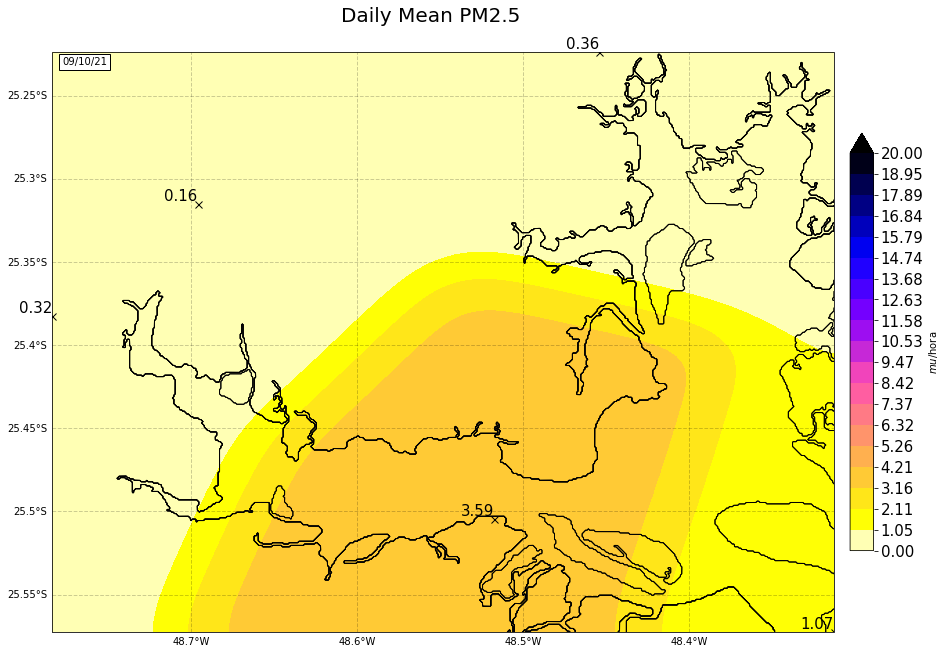

In [21]:

print(f"Matriz média diária {len(matrix_dailymean[name_estacao[0]].index)}")
#for t in range(len(matrix_dailymean[name_estacao[0]].index)):
for t in [0]:
    print(f"day {t} {matrix_dailymean[name_estacao[0]].index[t]} matrix_dailymean",xs.shape,ys.shape)
    
    
    matrix=np.empty(len(name_estacao)); #criar matriz para interpolação
    matrix[:]=np.nan
    for i in range(len(name_estacao)):
       try:
          matrix[i] = matrix_dailymean[name_estacao[i]][t] #recebe dado de cada estação i para o dia t
       except:
          pass
    print(matrix)
    
    
    plotar_mapa_calor(matrix, matrix_dailymean[name_estacao[0]].index[t], dayformat='%d/%m/%y',
                  c_levels=np.linspace(0,20,20), cmap="gnuplot2_r",
                  titulo_str= 'Daily Mean PM2.5', namefig=f"heatmap_daymean_{t}.png") 
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html